In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np


In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader


In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = CustomDataset(csv_file='mnist_train.csv', transform=transform)
test_dataset = CustomDataset(csv_file='mnist_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
target_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(target_model.parameters(), lr=0.001)

In [10]:
target_model.train()
for epoch in range(5):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = target_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluate the model on the original test set
target_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = target_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

original_accuracy = correct / total
print(f'Original Test Accuracy: {original_accuracy:.4f}')

Original Test Accuracy: 0.9827


In [11]:
# Initialize the surrogate model
surrogate_model = CNN()
optimizer = optim.Adam(surrogate_model.parameters(), lr=0.001)

# Train the surrogate model
surrogate_model.train()
for epoch in range(5):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = surrogate_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluate the surrogate model on the original test set
surrogate_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = surrogate_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

surrogate_accuracy = correct / total
print(f'Surrogate Model Test Accuracy: {surrogate_accuracy:.4f}')


Surrogate Model Test Accuracy: 0.9824


In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

def create_adversarial_pattern(model, data, target):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    return data_grad.sign()

# Generate adversarial examples
data_iter = iter(test_loader)
data, target = next(data_iter)
epsilon = 0.3
data_grad = create_adversarial_pattern(surrogate_model, data, target)
adv_data = data + epsilon * data_grad
adv_data = torch.clamp(adv_data, 0, 1)


In [21]:
# Evaluate the target model on adversarial examples
correct = 0
total = 0
with torch.no_grad():
    output = target_model(adv_data)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

adv_accuracy = correct / total
print(f'Adversarial Test Accuracy: {adv_accuracy:.4f}')

# Compare accuracies
print(f'Original Test Accuracy: {original_accuracy:.4f}')
print(f'Adversarial Test Accuracy: {adv_accuracy:.4f}')


Adversarial Test Accuracy: 0.0000
Original Test Accuracy: 0.9827
Adversarial Test Accuracy: 0.0000


In [25]:
def create_adversarial_pattern(model, data, target):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    return data_grad.sign()

In [26]:
def evaluate_adversarial_examples(model, test_loader, epsilon):
    correct = 0
    total = 0
    model.eval()
    for data, target in test_loader:
        data.requires_grad = True
        data_grad = create_adversarial_pattern(surrogate_model, data, target)
        adv_data = data + epsilon * data_grad
        adv_data = torch.clamp(adv_data, 0, 1)
        output = model(adv_data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    return correct / total

Epsilon: 0.00, Adversarial Test Accuracy: 0.5448
Epsilon: 0.01, Adversarial Test Accuracy: 0.5248
Epsilon: 0.05, Adversarial Test Accuracy: 0.4203
Epsilon: 0.10, Adversarial Test Accuracy: 0.3082
Epsilon: 0.15, Adversarial Test Accuracy: 0.2365
Epsilon: 0.20, Adversarial Test Accuracy: 0.1981
Epsilon: 0.25, Adversarial Test Accuracy: 0.1773
Epsilon: 0.30, Adversarial Test Accuracy: 0.1634


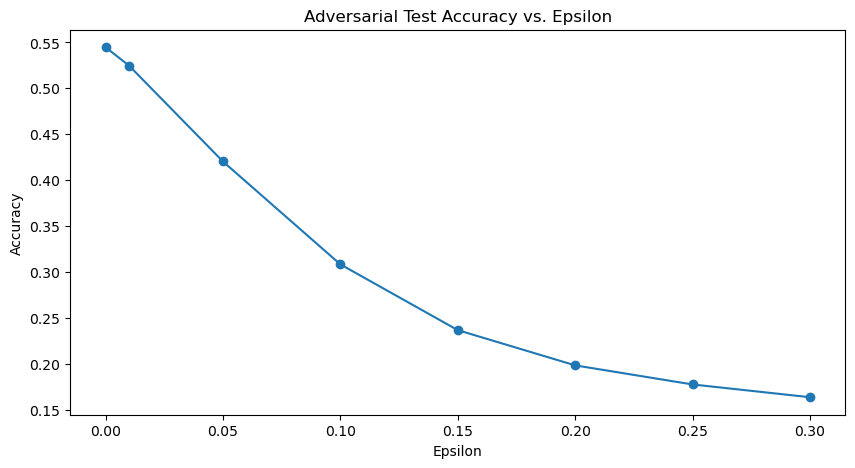

In [29]:
import matplotlib.pyplot as plt

epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

for epsilon in epsilons:
    accuracy = evaluate_adversarial_examples(target_model, test_loader, epsilon)
    accuracies.append(accuracy)
    print(f'Epsilon: {epsilon:.2f}, Adversarial Test Accuracy: {accuracy:.4f}')

# Display the results
plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker='o')
plt.title('Adversarial Test Accuracy vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader


In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = CustomDataset(csv_file='mnist_train.csv', transform=transform)
test_dataset = CustomDataset(csv_file='mnist_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
target_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(target_model.parameters(), lr=0.001)

In [8]:
def create_adversarial_pattern(model, data, target):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    return data_grad.sign()

def adversarial_training(model, train_loader, epsilon):
    model.train()
    for data, target in train_loader:
        # Forward pass
        data.requires_grad = True
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Generate adversarial examples
        data_grad = data.grad.data
        adv_data = data + epsilon * data_grad.sign()
        adv_data = torch.clamp(adv_data, 0, 1)
        
        # Forward pass on adversarial examples
        adv_output = model(adv_data)
        adv_loss = criterion(adv_output, target)
        
        # Backward pass on adversarial examples
        model.zero_grad()
        adv_loss.backward()
        optimizer.step()


In [9]:
epsilon = 0.1  # You can adjust this value
num_epochs = 5

for epoch in range(num_epochs):
    adversarial_training(target_model, train_loader, epsilon)
    print(f'Epoch {epoch+1}/{num_epochs} completed.')

# Evaluate the model on the original test set
target_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = target_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

original_accuracy = correct / total
print(f'Original Test Accuracy after Adversarial Training: {original_accuracy:.4f}')

Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Original Test Accuracy after Adversarial Training: 0.9782
